In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from anim import make_3d_animation
from IPython.display import HTML

In [2]:
L = 10 # box length
N = 4 # number of particles
dt = 0.001 # timestep
temperature = 10 # temperature 

In [3]:
positions = L*np.random.random((N,3)) # np.array(np.random.randn(N,2)) # initial positions
velocities = np.zeros([N,3]) # np.array(np.random.randn(N,2)) # initial velocities
accelerations = np.zeros([N,3]) # np.array(np.random.randn(N,2)) # initial accelerations

In [4]:
def fcc():
    # fcc lattice is created using an algorithm following ...
    # If the number of atoms N = 4*M^3, with M a positive integer, then the atoms can fill a cubical volume in the fcc lattice
    # Find the largest M possible:
    M = 1 
    b = 2 # lattice constant of conventional cubic unit cell
    while 4*(M**3) < N:
        M = M + 1
    b = L/M
    # Create the fcc lattice:
    xCell = [0.25, 0.75, 0.75, 0.25]
    yCell = [0.25, 0.75, 0.25, 0.75]
    zCell = [0.25, 0.25, 0.75, 0.75]
    count = 0 # keeps track of atoms placed on the lattice
    p = np.zeros([N,3]) # p; NxDim matrix where each row contains the position of a particle (x, y, z)
    for i in range(M):
        for j in range(M):
            for k in range(M):
                for m in range(4):
                    if count < N:
                        p[count,0] = (i + xCell[m])*b
                        p[count,1] = (j + yCell[m])*b
                        p[count,2] = (k + zCell[m])*b
                        count = count + 1
             
    return(p)


In [5]:
def MB_velocity_distribution():
    # function that returns Maxwell-Boltzmann velocity distribution for temperature in units of (m/Kb)
    mean = 0
    std_dev = np.sqrt(temperature)
    v = np.random.normal(mean,std_dev,size=(N,3))
   
    return(v)

In [6]:
def instant_temp(k):
    
    # k is kinetic energy
    inst_T = 2*k/(3*(N-1))
    
    return(inst_T)

In [7]:
def rescale_velocities(v,k):
    # v; (N,3) velocity array
    # k; kinetic energy
    l = np.sqrt(((N-1)*3*temperature)/(2*k))
    v = l*v
    
    return(v)
    

In [8]:
def move_euler(p,v,a):
    # p; NxDim matrix where each row contains the position of a particle (x, y, z)
    # v; NxDim matrix where each row contains the velocity of a particle (Vx, Vy, Vz)
    # a; NxDim matrix where each row contains the acceleration of a particle (Ax, Ay, Az)
    p_0 = p
    p = p + v*dt
    v = v + a*dt
    a = forces_potential(p_0)['f']
    
    return(p,v,a)
    

In [9]:
def move_verlet(p,v,a):
    # p; NxDim matrix where each row contains the position of a particle (x, y, z)
    # v; NxDim matrix where each row contains the velocity of a particle (Vx, Vy, Vz)
    # a; NxDim matrix where each row contains the acceleration of a particle (Ax, Ay, Az)
    p = p + v*dt + ((dt**2)/2)*a
    a_0 = a
    a = forces_potential_virial(p)['f']
    v = v + (dt/2)*(a + a_0)
    
    return(p,v,a)

In [10]:
def wall_interaction(p):
    # p; matrix with as rows the positions of the particles
    p = p%L # ensure the positions are subject to periodic boundary conditions
    
    return(p)

In [11]:
def distances(p):
    # p; matrix with as rows the positions of the particles
    p_x = p[:,0]
    p_x_copy = np.array([p_x]*N) # make matrix with copies of x positions as rows
    d_x = p_x_copy.transpose() - p_x_copy # matrix that encodes all distances between all particles
    # same for y and z:    
    p_y = p[:,1]
    p_y_copy = np.array([p_y]*N) 
    d_y = p_y_copy.transpose() - p_y_copy
    
    p_z = p[:,2]
    p_z_copy = np.array([p_z]*N) 
    d_z = p_z_copy.transpose() - p_z_copy
    
    d_x = (d_x + L/2) % L - L/2 # this ensures the distances follow the minimal image convention 
    d_y = (d_y + L/2) % L - L/2
    d_z = (d_z + L/2) % L - L/2
    d_r = np.sqrt(d_x**2 + d_y**2 + d_z**2) # compute radial distance between particles
    
    return({'d_x': d_x, 'd_y': d_y, 'd_z': d_z, 'd_r': d_r})

In [12]:
def forces_potential_virial(p):
    # p; matrix with as rows the positions of the particles
    # b; bin edges for the histogram needed for the pair correlation function
    x = distances(p)['d_x']
    y = distances(p)['d_y']
    z = distances(p)['d_z']
    r = distances(p)['d_r']
    # compute forces:
    f_x = 24*((2/r**14)-(1/r**8))*x # matrix that encodes all the forces on each particle from each particle
    f_y = 24*((2/r**14)-(1/r**8))*y
    f_z = 24*((2/r**14)-(1/r**8))*z
    f_x = np.nansum(f_x, axis=1) # 1D array that contains for each index the total force on the particle associated with that index
    f_y = np.nansum(f_y, axis=1)
    f_z = np.nansum(f_z, axis=1)
    f = np.column_stack((f_x, f_y, f_z))
    #compute potental energy
    U = 4*((1/(r**12))-(1/(r**6))) # matrix encoding all the potentials for each particle from each particle
    U[U==np.inf] = np.nan # convert inf on the diagnal from divding by zero to nan
    U = np.nansum(U)/2 # total potential energy for each particle, divide by 2 because we count the potential double
    # (potential of particle i with j and vice versa)
    # compute virial:
    virial = f*p
    virial = np.sum(virial)
    
    # make histogram of distances needed for the correlation function
    r = np.triu(r) # select upper echelon of r to prevent counting pair distances double
    h, b = np.histogram(r[r!=0], bins=bin_edges) 
    h = np.array(h)
    
    return({'f': f, 'U': U, 'V': virial, 'h': h})

In [13]:
def kinetic(v):
    v_x = v[:,0]
    v_y = v[:,1]
    v_z = v[:,2]
    v = np.sqrt(v_x**2 + v_y**2 + v_z**2)
    T = 0.5*(v**2) # 1D array with all the kinetic energies for each particle
    T = np.sum(T) # total potential energy
    
    return(T)

In [14]:
def average(A):
    # A; 1D array with values that need to be averaged over
    #avg = sum(A)/len(A)
    
    return(avg)

In [15]:
def bootstrap_error(A):
    # A; 1D array of N data points
    n = 100 # number of samples that need to be created
    store = [] # empty list to store sample averages
    for i in range(n):
        rA = np.random.choice(A,(len(A))) # resample copy of A
        rA_avg = np.mean(rA) # create sample average
        store.append(rA_avg)
    store = np.array(store)
    sigma = np.sqrt(np.mean(store**2)-(np.mean(store)**2)) # standard deviation in the (sample)average of A
    
    return(sigma)

In [16]:
def pressure(T,V,T_e,V_e):
    # T, T_e average temperature and error
    # V, V_e average virial and error
    pressure = (1/L**3)*(N*T_avg + (V_avg/3))
    error = (1/L**3)*np.sqrt((N*T_e)**2 + (V_e/3)**2) # standard propagation of error method is used
    
    return(pressure, error)

In [17]:
def specific_heat(K):
    K_avg = average(K)
    dK = K - K_avg # fluctuation in kinetic energy
    Cv = (3*N*(K_avg**2))/(2*(K_avg**2)-3*N*average((dK**2)))
    
    return(Cv)

# Verlet simulation

In [18]:
# set phases:
solid = {'rho': 1.2, 'temperature': 0.5}
liquid = {'rho': 0.8, 'temperature': 1}
gas = {'rho': 0.3, 'temperature': 3}
phases = {'solid': solid, 'liquid': liquid, 'gas': gas}

In [22]:
# set phase (give string 'solid', 'liquid' or 'gas':
ph = 'methods'

# parameters (note that these are global!)
rho = 0.88#phases[ph]['rho'] # density
N = 108 # number of particles
L = (N/rho)**(1/3) # box length
temperature = 1#phases[ph]['temperature'] 
dt = 0.004 # timestep
time_steps = 5000
equilibrium_time = 500 # number of timesteps the system is allowed to come to equilibrium without rescaling
rescaling_interval = 20 # number of timesteps between rescaling of velocities
production_time = 3000 # time_step to start the production phase (after the system has equilibrated from rescaling)
bin_edges = np.linspace(0,L/2,N) # set bin edges for the histogram needed for the pair correlation function

# intialise:
positions = fcc() # L*np.random.random((N,3)) # np.array(np.random.randn(N,2)) # initial positions
velocities = MB_velocity_distribution() # np.array(np.random.randn(N,2)) # initial velocities
accelerations = np.zeros([N,3]) # np.array(np.random.randn(N,2)) # initial accelerations

# simulation: 
U = [] # empty list for the potential energy at each time step
K = [] # empty list for the kinetic energy at each time step
T = [] # empty list for the instantaneous temperature at each time step
V = [] # empty list for the virial at each time step
traj = np.zeros([time_steps,N,3]) # 3D array that contains the trajectory of N particles
hist_matrix = np.zeros([time_steps,N-1]) # array that contains a histogram of the pair correlation number in each timestep 

for i in range(time_steps):
    positions = wall_interaction(positions)
    
    traj[i] = positions
    f_U_V = forces_potential_virial(positions)
    pot_energy = f_U_V['U']
    kin_energy = kinetic(velocities)
    temp = instant_temp(kin_energy)
    vir = f_U_V['V']
    U.append(pot_energy)
    K.append(kin_energy)
    T.append(temp)
    V.append(vir)
    
    hist_matrix[i] = f_U_V['h']
    
    positions, velocities, accelerations = move_verlet(positions,velocities,accelerations)
 
    if equilibrium_time < i < production_time:
        if i%rescaling_interval == 0:
            velocities = rescale_velocities(velocities,kin_energy)
    
# anim = make_3d_animation(L,traj,delay=10,rotate_on_play=0,initial_view=(30,20))
# HTML(anim.to_html5_video())

C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in subtract
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in subtract
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in subtract
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in sub

# Results

In [26]:
# plot potential energy (units of epsilon), kinetic energy (units of epsilon) and temperature (units of kB)
U = np.array(U)/N
#U = U - min(U)
K = np.array(K)/N
T = np.array(T)
t = np.arange(time_steps)*dt
plt.figure()           
plt.plot(t, U, color = 'blue', label = 'potential')
plt.plot(t, K, color = 'red', label = 'kinetic')

E = U + K
plt.plot(t, E, color = 'yellow', label ='total')
plt.legend(loc = 'best')
# plt.axis(xmin=4, xmax=5, ymin=-452.5, ymax=-451.5)
plt.show()

plt.figure()
plt.plot(t, T, color = 'red', label = 'temperature', linestyle = '--')
plt.legend(loc = 'best')
#plt.axis(ymin=0, ymax=1.6*temperature)
plt.show()

np.savetxt('raw_time_'+ph, t)
np.savetxt('raw_U_'+ph, U)
np.savetxt('raw_K_'+ph, K)
np.savetxt('raw_T_'+ph, T)

[ 0.89335886  0.89245786  0.88938434 ...,  0.99766293  0.99368376
  0.99212025]


In [24]:
# canonnical averages:
U_avg = np.mean(U[production_time:])
K_avg = np.mean(K[production_time:])
E_avg = np.mean(E[production_time:])
T_avg = np.mean(T[production_time:])
V = np.array(V)
V_avg = np.mean(V[production_time:])

U_e = bootstrap_error(U[production_time:])
K_e = bootstrap_error(K[production_time:])
T_e = bootstrap_error(T[production_time:])
V_e = bootstrap_error(V[production_time:])

P, P_e = pressure(T_avg,V_avg,T_e,V_e)

canonical_averages = {'U': U_avg, 'U_e': U_e, 'K': K_avg, 'K_e': K_e, 'T': T_avg, 'T_e': T_e, 'P': P, 'P_e': P_e}

import pickle
pickle.dump(canonical_averages, open( ph+'.p', 'wb' )) # save data as dictionary, note that one has to open with pickle

print('potential:', U_avg, '+-', U_e, '\nkinetic:', K_avg, '+-', K_e, '\ntotal:', E_avg, '\ntemperature:', T_avg, '+-'
      , T_e, '\npressure:', P, '+-', P_e)

potential: -5.91642774213 +- 0.00228141064778 
kinetic: 1.41382214768 +- 0.00223576760034 
total: -4.50260559445 
temperature: 0.951356959185 +- 0.00166408295329 
pressure: 0.703341576292 +- 0.0220685485342


In [25]:
# correlation function: 
r = bin_edges[1:]/2 
n_avg = np.mean(hist_matrix,axis=0) # average of the pair correlation number for each bin
g = (2*L**3/(N*(N-1)))*n_avg/((4*np.pi*r[1]*r**2)) # compute correlation function:
    
plt.plot(r,g,label='g',color='orange')
#plt.axis(xmax=2)
plt.legend()
plt.show()
np.savetxt('r.txt', r)
np.savetxt('g_'+ph, g)

In [77]:
specific_heat(K[production_time:])/N

TypeError: slice indices must be integers or None or have an __index__ method

In [301]:
w = P/(rho*T_avg)
print(w)

0.98201560265


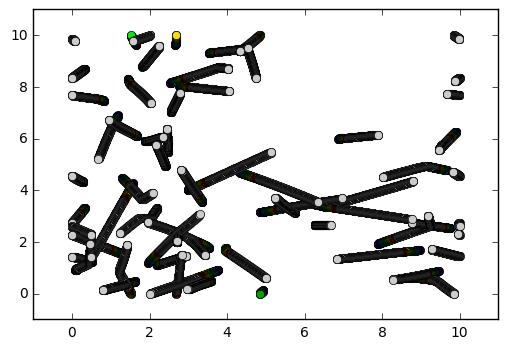

In [25]:
cmap = plt.get_cmap('spectral')

for i in range(time_steps):
    positions = wall_interaction(positions)
  
    plt.plot(positions[:,0], positions[:,1], marker = 'o', color=cmap(i*2), linestyle='')
    plt.axis(xmax=L+1, xmin=-1, ymax=L+1, ymin=-1)
    
    p0 = positions
    v0 = velocities
    a0 = accelerations
    positions, velocities, accelerations = move_verlet(p0,v0,a0)

plt.show()

# Euler simulation

In [76]:
L = 10 # box length
N = 32 # number of particles
dt = 0.001 # timestep
temperature = 10 
time_steps = 1000

positions = fcc() # L*np.random.random((N,3)) # np.array(np.random.randn(N,2)) # initial positions
velocities = MB_velocity_distribution() # initial velocities
accelerations = np.zeros([N,3]) # np.array(np.random.randn(N,2)) # initial accelerations

U = [] # empty list for the potential energy at each time step
K = [] # empty list for the kinetic energy at each time step
T = [] # empty list for the instantaneous temperature at each time step

traj = np.zeros([time_steps,N,3])

for i in range(time_steps):
    positions = wall_interaction(positions)
    
    traj[i] = positions
    pot_energy = forces_potential(positions)['U']
    kin_energy = kinetic(velocities)
    temp = instant_temp(kin_energy)
    U.append(pot_energy)
    K.append(kin_energy)
    T.append(temp)
    
    p0 = positions
    v0 = velocities
    a0 = accelerations
    positions, velocities, accelerations = move_euler(p0,v0,a0)
    # rescaling: 
    if (i+1)%20 == 20:
        velocities = rescale_velocities(velocities,kin_energy)
    
#anim = make_3d_animation(L,traj,delay=10,rotate_on_play=0)
#HTML(anim.to_html5_video())


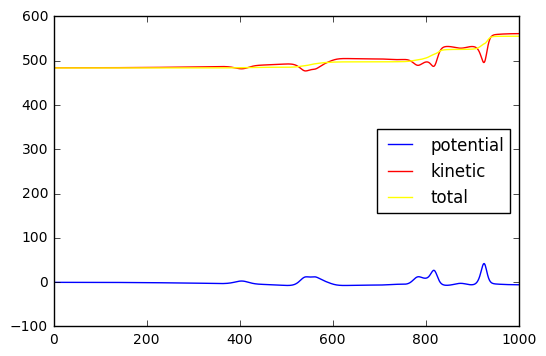

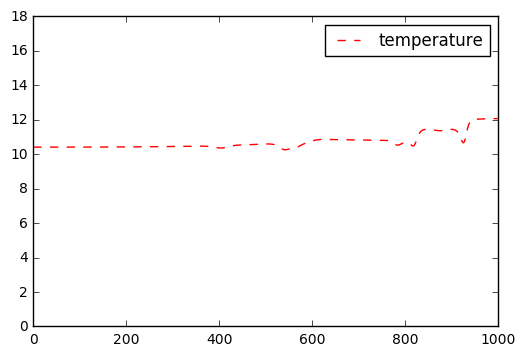

In [77]:
# plot potential energy (units of epsilon) and kinetic energy (in units of epsilon/m)
#U = U - min(U)
plt.figure()
plt.plot(range(time_steps), U, color = 'blue', label = 'potential')
plt.plot(range(time_steps), K, color = 'red', label = 'kinetic')

U = np.array(U)
K = np.array(K)
E = U + K
plt.plot(range(time_steps), E, color = 'yellow', label = 'total')
plt.legend(loc = 'best')

plt.show()

plt.figure()
plt.plot(range(time_steps), T, color = 'red', label = 'temperature', linestyle = '--')
plt.legend(loc = 'best')
plt.axis(ymin=0,ymax=1.8*temperature)
plt.show()

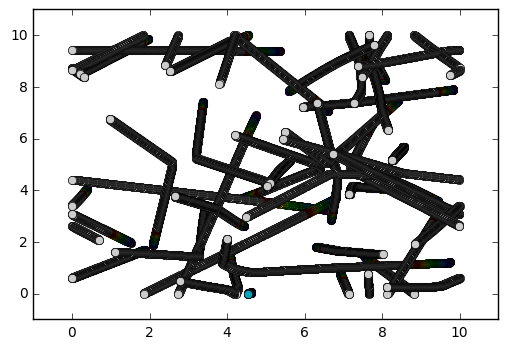

In [16]:
cmap = plt.get_cmap('spectral')

for i in range(time_steps):
    positions = wall_interaction(positions)
  
    plt.plot(positions[:,0], positions[:,1], marker = 'o', color=cmap(i*2), linestyle='')
    plt.axis(xmax=L+1, xmin=-1, ymax=L+1, ymin=-1)
    
    p0 = positions
    v0 = velocities
    a0 = accelerations
    positions, velocities, accelerations = move_euler(p0,v0,a0)

plt.show()

# Debugging

In [34]:
def compressibility(P,T,P_e,T_e):
    compressibility = P/(rho*T)
    error = (1/(rho*T))*np.sqrt(P_e**2 + ((P/T)**2)*(T_e**2))
    
    return(compressibility, error)

In [70]:
b = np.arange(0,L,L/N)
h = forces_potential_virial(positions)['h']

print(distances(positions)['d_r'])
print(h,b)

[[ 0.          1.05627723  1.05627723  1.05627723]
 [ 1.05627723  0.          1.05627723  1.05627723]
 [ 1.05627723  1.05627723  0.          1.05627723]
 [ 1.05627723  1.05627723  1.05627723  0.        ]]
[0 0 6] [ 0.          0.3734504   0.74690079  1.12035119]


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in subtract


In [80]:
# If the number of atoms N = 4*M^3, with M a positive integer, then the atoms can fill a cubical volume in the fcc lattice

M = 1
while 4*(M**3) < N:
    b = L/M # lattice constant of conventional cubic unit cell
    M = M + 1
print(b, M)
# fcc lattice is created using an algorithm following ...
xCell = [0.25, 0.75, 0.75, 0.25]
yCell = [0.25, 0.75, 0.25, 0.75]
zCell = [0.25, 0.25, 0.75, 0.75]

count = 0 # keeps track of how many atoms are placed on the lattice

for i in range(M):
    for j in range(M):
        for k in range(M):
            for l in range(4):
                if count < N:
                    positions[count,0] = (i + xCell[l])*b
                    positions[count,1] = (j + yCell[l])*b
                    positions[count,2] = (k + zCell[l])*b
                    count = count + 1
                    print(positions)


12.5 5
[[ 3.125  3.125  3.125]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 9.375  3.125  9.375]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 9.375  3.125  9.375]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 9.375  3.125  9.375]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 9.375  3.125  9.375]
 ..., 
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]]
[[ 3.125  3.125  3.125]
 [ 9.375  9.375  3.125]
 [ 9.375  3.125  9.375]
 ..., 
 [

In [28]:
def fcc():
    # input is positions array p and lattice constant b
    r = N%L
    
    f = L/b # number of free positions of the lattice in a row
    f = int(f)
    n = int((N-r)/f)  # minimum number of rows needed for the lattice
    row1 = np.arange(0,L,b)
    row2 = np.arange(b/2,L,b)


    x = []
    y = []

    for i in range(n):
        col = np.tile((i/2)*b,f)
        y.append(col)
        if i%2 == 0:
            x.append(row1)
        else:
            x.append(row2)

    x = np.array(x)
    x = x.flatten()
    y = np.array(y)
    y = y.flatten()

    p[:n*f,0] = x
    p[:n*f,1] = y

    for j in range(r):
        if n%2 == 0:
            p[n*f+j,0] = j*b
        else:
            p[n*f+j,0] = b*(j+1)/2
        p[n*f+j,1] = (n/2)*b
      
    return(p)

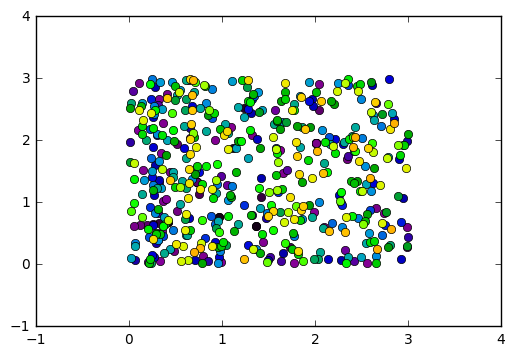

In [33]:
time_steps = 100
cmap = plt.get_cmap('spectral')

U = [] # empty list for the potential energy at each time step
T = [] # empty list for the kinetic energy at each time step

for i in range(time_steps):
    positions = wall_interaction(positions)
    #print(positions)
  
    plt.plot(positions[:,0], positions[:,1], marker = 'o', color=cmap(i*2), linestyle='')
    plt.axis(xmax=L+1, xmin=-1, ymax=L+1, ymin=-1)
    pot_energy = forces_potential(positions)['U']
    kin_energy = kinetic(velocities)
    U.append(pot_energy)
    T.append(kin_energy)
    
    p0 = positions
    v0 = velocities
    a0 = accelerations
    positions, velocities, accelerations = move_verlet(p0,v0,a0)

plt.show()

In [14]:
time_steps = 300

U = [] # empty list for the potential energy at each time step
T = [] # empty list for the kinetic energy at each time step
traj = np.zeros([time_steps,N,3])

for i in range(time_steps):
    positions = wall_interaction(positions)
    
    traj[i] = positions
    pot_energy = forces_potential(positions)['U']
    kin_energy = kinetic(velocities)
    U.append(pot_energy)
    T.append(kin_energy)
    
    p0 = positions
    v0 = velocities
    a0 = accelerations
    positions, velocities, accelerations = move_euler(p0,v0,a0)
    
anim = make_3d_animation(L,traj,delay=10,rotate_on_play=0)
plt.show()
#HTML(anim.to_html5_video())



In [70]:
time_steps = 2
traj = np.zeros([time_steps,N,3])
traj[0] = np.random.random((N,3))
print(traj)

[[[ 0.66916027  0.31492139  0.43598423]
  [ 0.75824202  0.46127447  0.42115942]
  [ 0.61725031  0.15744928  0.50781648]
  [ 0.83142249  0.41923464  0.28086554]
  [ 0.67987016  0.42972165  0.64894749]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]


In [33]:
initial_positions

,0,1
0,0.218241,0.242700
1,0.922515,0.138346
2,0.742174,0.101740
3,0.672073,0.814270
4,0.825320,0.543596


In [5]:
initial_velocities

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [6]:
initial_accelerations

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [3]:
initial_positions = pd.DataFrame(a)#,columns=['x','y'])
initial_velocities = pd.DataFrame(b)#,columns=['Vx','Vy'])
initial_accelerations = pd.DataFrame(c)#,columns=['Ay','Ay'])

In [865]:
r = N%L
b = 2
f = L/b # number of free positions of the lattice in a row
n = int((N-r)/f)  # minimum number of rows needed for the lattice

print(n)
row1 = np.arange(0,L,b)
row2 = np.arange(1/2,L,b)
x = []
y = []

for i in range(n):
    col = np.tile(i/2,L)
    y.append(col)
    if i%2 == 0:
        x.append(row1)
    else:
        x.append(row2)


x = np.array(x)
x = x.flatten()
y = np.array(y)
y = y.flatten()
print(x)
print(y)
positions[:n*L,0] = x
positions[:n*L,1] = y


for j in range(r):
    if n%2 == 0:
        positions[n*L+j,0] = j
    else:
        positions[n*L+j,0] = (j+1)/2
    positions[n*L+j,1] = n/2

print(positions)

2
[ 0.   2.   0.5  2.5]
[ 0.   0.   0.   0.   0.5  0.5  0.5  0.5]


ValueError: could not broadcast input array from shape (4) into shape (5)

In [838]:
r = N%L
b = 2
f = L/b # number of free positions of the lattice in a row
f = int(f)
n = int((N-r)/f)  # minimum number of rows needed for the lattice
print(n,f)
row1 = np.arange(0,L,b)
row2 = np.arange(b/2,L,b)
print(row1,row2)

x = []
y = []

for i in range(n):
    col = np.tile((i/2)*b,f)
    y.append(col)
    if i%2 == 0:
        x.append(row1)
    else:
        x.append(row2)


x = np.array(x)
x = x.flatten()
y = np.array(y)
y = y.flatten()
print(x)
print(y)

positions[:n*f,0] = x
positions[:n*f,1] = y


for j in range(r):
    if n%2 == 0:
        positions[n*f+j,0] = j
    else:
        positions[n*f+j,0] = (j+1)/2
    positions[n*f+j,1] = n/2
    
print(positions)

2 2
[0 2] [ 1.  3.]
[ 0.  2.  1.  3.]
[ 0.  0.  1.  1.]
[[ 0.  0.]
 [ 2.  0.]
 [ 1.  1.]
 [ 3.  1.]
 [ 0.  1.]]


In [815]:
n = N/2 # number of particles along a row of the lattice
l = L/n # lattice constant
count = 0 # will keep track of particles put on the lattice
i = 0 # row index
j = 0 # column index
row1 = np.arange(0,L)
row2 = np.arange(1/2,L)



In [834]:
row1 = np.arange(0,L)
row2 = np.arange(1/2,L)

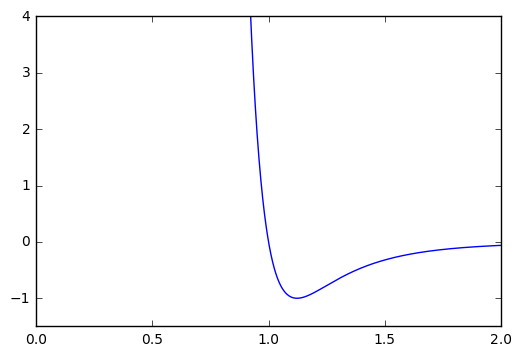

In [118]:
r = np.array(np.arange(0.1,100,0.001))
U = 4*((1/(r**12))-(1/(r**6)))
plt.plot(r,U)
plt.axis(xmax=2, ymax=4, ymin = -1.5)
plt.show()

In [105]:
np.ediff1d

<function numpy.lib.arraysetops.ediff1d>

In [118]:
#print(velocities)
v_x =  velocities[:,0]
v_y = velocities[:,1]
v = np.sqrt(v_x**2 + v_y**2)
print(v)
T = 0.5*(v**2)
print(T)# 

[ 2.48181244  1.88480757  2.30321913]
[ 3.0796965   1.77624978  2.65240919]


In [115]:
r = distances(positions)['d_r']
print(r)
U = (1/r)*2#4*((1/(r**12))-(1/(r**6)))
print(U)
U[U==np.inf] = np.nan 
print(U)
U = np.nansum(U)/2 # 
print(U)

[[ 0.          4.86295654  5.35485079]
 [ 4.86295654  0.          4.23224658]
 [ 5.35485079  4.23224658  0.        ]]
[[        inf  0.41127244  0.37349313]
 [ 0.41127244         inf  0.47256226]
 [ 0.37349313  0.47256226         inf]]
[[        nan  0.41127244  0.37349313]
 [ 0.41127244         nan  0.47256226]
 [ 0.37349313  0.47256226         nan]]
1.25732783019


In [68]:
positions[0,0] = 15
positions = wall_interaction(positions)

In [15]:
positions, velocities = move(positions,velocities,accelerations)

In [16]:
positions

array([[ 15.0007045 ,   0.40044271],
       [  0.80921826,   0.64867646]])

In [17]:
positions = wall_interaction(positions)
print(positions)

[[ 15.0007045    0.40044271]
 [  0.80921826   0.64867646]]


In [41]:
positions = np.array(positions)

In [371]:
positions

array([[  9.73302096,   1.86592244],
       [ 12.4767236 ,   5.91843812],
       [  8.41082734,  18.28688961],
       [ 15.84409876,  12.59750423]])

In [385]:
positions_x = positions[:,0]
x_copy = np.array([positions_x,]*N)
print(x_copy)
distances_x = x_copy.transpose() - x_copy

positions_y = positions[:,1]
y_copy = np.array([positions_y,]*N)
distances_y = y_copy.transpose() - y_copy





[[  9.73302096  12.4767236    8.41082734  15.84409876]
 [  9.73302096  12.4767236    8.41082734  15.84409876]
 [  9.73302096  12.4767236    8.41082734  15.84409876]
 [  9.73302096  12.4767236    8.41082734  15.84409876]]


In [386]:
print(distances_x)
print(distances_y)

[[ 0.         -2.74370264  1.32219362 -6.1110778 ]
 [ 2.74370264  0.          4.06589626 -3.36737515]
 [-1.32219362 -4.06589626  0.         -7.43327142]
 [ 6.1110778   3.36737515  7.43327142  0.        ]]
[[  0.          -4.05251568 -16.42096717 -10.73158179]
 [  4.05251568   0.         -12.36845149  -6.67906611]
 [ 16.42096717  12.36845149   0.           5.68938538]
 [ 10.73158179   6.67906611  -5.68938538   0.        ]]


In [387]:
distances_x = (distances_x + L/2) % L - L/2
distances_y = (distances_y + L/2) % L - L/2

In [388]:
print(distances_x)
print(distances_y)

[[ 0.         -2.74370264  1.32219362 -6.1110778 ]
 [ 2.74370264  0.          4.06589626 -3.36737515]
 [-1.32219362 -4.06589626  0.         -7.43327142]
 [ 6.1110778   3.36737515  7.43327142  0.        ]]
[[ 0.         -4.05251568  3.57903283  9.26841821]
 [ 4.05251568  0.          7.63154851 -6.67906611]
 [-3.57903283 -7.63154851  0.          5.68938538]
 [-9.26841821  6.67906611 -5.68938538  0.        ]]


In [389]:
distances_r = np.sqrt(distances_x**2 + distances_y**2)

In [390]:
distances_r

array([[  0.        ,   4.89395418,   3.81545174,  11.10174977],
       [  4.89395418,   0.        ,   8.64708304,   7.47991575],
       [  3.81545174,   8.64708304,   0.        ,   9.36069602],
       [ 11.10174977,   7.47991575,   9.36069602,   0.        ]])

In [391]:
forces_x = -(1/distances_r**2)*distances_x
forces_y = -(1/distances_r**2)*distances_y

In [392]:
forces_x

array([[        nan,  0.11455584, -0.09082452,  0.04958324],
       [-0.11455584,         nan, -0.05437722,  0.06018636],
       [ 0.09082452,  0.05437722,         nan,  0.08483278],
       [-0.04958324, -0.06018636, -0.08483278,         nan]])

In [393]:
accelerations_x = np.nansum(forces_x, axis=1)
print(accelerations_x)
accelerations = np.array(accelerations)
print(accelerations)

[ 0.07331456 -0.10874671  0.23003453 -0.19460239]
[[ 0.07331456  0.05863069]
 [-0.10874671  0.07963669]
 [ 0.23003453  0.17227038]
 [-0.19460239  0.43508621]]


In [381]:
accelerations = np.array(accelerations)
for i in range(N):
    accelerations[i,0] = accelerations_x[i]

In [382]:
accelerations

array([[ 0.07331456,  0.05863069],
       [-0.10874671,  0.07963669],
       [ 0.23003453,  0.17227038],
       [-0.19460239,  0.43508621]])